## Tesla Stock Forecasting with Long Short-Term Memory

In [107]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler

# Importing plotly to build interactive graphs
import plotly.graph_objects as go

# Importing the deepcopy function from the copy
from copy import deepcopy as dc

In [108]:
# Reading the csv file
# Source: https://finance.yahoo.com/quote/TSLA/history?period1=1277769600&period2=1687132800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
data = pd.read_csv('TSLA.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [109]:
# Subsetting 'Date' and 'Close' columns from the dataframe
data = data[['Date', 'Close']]
data

,Date,Close
0,2010-06-29,1.592667
1,2010-06-30,1.588667
2,2010-07-01,1.464000
3,2010-07-02,1.280000
4,2010-07-06,1.074000
...,...,...
3260,2023-06-12,249.830002
3261,2023-06-13,258.709991
3262,2023-06-14,256.790009
3263,2023-06-15,255.899994


In [110]:
# Checking if a CUDA-enabled GPU is available
# If available, assign 'cuda:0' to the device variable; otherwise, assign 'cpu'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [111]:
# Checking the datatype of 'Date' column
data['Date'].dtype

dtype('O')

In [112]:
# Converting 'Date' column from object to datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [113]:
# Creating a trace with red line color
trace = go.Scatter(
    x=data['Date'],  # X-axis values representing dates
    y=data['Close'],  # Y-axis values representing closing prices
    mode='lines',  # Specify the mode as 'lines' for a line plot
    line=dict(color='blue')  # Set the line color to red
)

# Creating the layout for the plot
layout = go.Layout(
    title='Closing Prices Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price')
)

# Combining the trace and layout into a Figure object
figure = go.Figure(data=[trace], layout=layout)

# Displing the plot
figure.show()

In [114]:
# Displaying the plot
figure.show()

# Function to prepare a DataFrame for LSTM input
def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)

  df.set_index('Date', inplace=True)

  for i in range(1, n_steps + 1):
    df[f'Close(t-{i})'] = df['Close'].shift(i)

  df.dropna(inplace=True)

  return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2010-07-09,1.160000,1.164000,1.053333,1.074000,1.280000,1.464000,1.588667,1.592667
2010-07-12,1.136667,1.160000,1.164000,1.053333,1.074000,1.280000,1.464000,1.588667
2010-07-13,1.209333,1.136667,1.160000,1.164000,1.053333,1.074000,1.280000,1.464000
2010-07-14,1.322667,1.209333,1.136667,1.160000,1.164000,1.053333,1.074000,1.280000
2010-07-15,1.326000,1.322667,1.209333,1.136667,1.160000,1.164000,1.053333,1.074000
...,...,...,...,...,...,...,...,...
2023-06-12,249.830002,244.399994,234.860001,224.570007,221.309998,217.610001,213.970001,207.520004
2023-06-13,258.709991,249.830002,244.399994,234.860001,224.570007,221.309998,217.610001,213.970001
2023-06-14,256.790009,258.709991,249.830002,244.399994,234.860001,224.570007,221.309998,217.610001


In [115]:
# Converting a DataFrame to a NumPy array
shifted_df_as_np = shifted_df.to_numpy()

In [116]:
# Normalizing data between -1 and 1 using Min-Max scaling
scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99988586, -0.99986629, -1.        , ..., -0.99799144,
        -0.9973817 , -0.99736213],
       [-1.        , -0.99988586, -0.99945873, ..., -0.99889138,
        -0.99799144, -0.9973817 ],
       [-0.99964452, -1.        , -0.99947829, ..., -0.99989892,
        -0.99889138, -0.99799144],
       ...,
       [ 0.25064823,  0.26004072,  0.21675974, ...,  0.09321381,
         0.0772692 ,  0.05917261],
       [ 0.2462943 ,  0.25064823,  0.26019152, ...,  0.14354188,
         0.09321381,  0.0772692 ],
       [ 0.26899311,  0.2462943 ,  0.25080094, ...,  0.19020172,
         0.14354188,  0.09321381]])

In [117]:
# Splitting data into input (X) and target (y) arrays
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((3258, 7), (3258,))

In [118]:
# Creating a deep copy of the reversed array
X = dc(np.flip(X, axis=1))

In [119]:
# Creating a split index with 95%
split_index = int(len(X)*0.95)

split_index

3095

In [120]:
# Preparing the training and testing data
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

In [121]:
# Checking the shape for training and testing data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3095, 7), (163, 7), (3095,), (163,))

In [122]:
# Reshaping arrays for LSTM input
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3095, 7, 1), (163, 7, 1), (3095, 1), (163, 1))

In [123]:
# Converting arrays to PyTorch tensors and adjusting data type
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3095, 7, 1]),
 torch.Size([163, 7, 1]),
 torch.Size([3095, 1]),
 torch.Size([163, 1]))

In [124]:
# Creating a custom dataset class for time series data

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [125]:
train_dataset

In [126]:
# Prepare data loaders for efficient training and testing using PyTorch DataLoader
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [127]:
# Iterate through the batches in the training loader, transferring data to the specified device (e.g., GPU),
# print the shapes, and break after the first batch
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [128]:
# Define a custom LSTM (Long Short-Term Memory) model by subclassing nn.Module.
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        
        # Initialize the model's hyperparameters.
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        # Create an LSTM layer using nn.LSTM.
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        
        # Create a fully connected (linear) layer for the final prediction.
        self.fc = nn.Linear(hidden_size, 1)

    # Implement the forward pass of the model.
    def forward(self, x):
        # Retrieve the batch size from the input tensor.
        batch_size = x.size(0)
        
        # Initialize initial hidden and cell states with zeros.
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        # Perform the forward pass through the LSTM layer.
        out, _ = self.lstm(x, (h0, c0))
        
        # Extract the output from the last time step and pass it through the linear layer.
        out = self.fc(out[:, -1, :])
        return out

# Create an instance of the custom LSTM model.
model = LSTM(1, 4, 1)

# Move the model to the specified device (e.g., GPU or CPU).
model.to(device)

# Print the model summary or return it for further use.
model


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [129]:
def train_one_epoch():
    # Set the model to training mode.
    model.train(True)
    
    # Print the current epoch.
    print(f'Epoch: {epoch + 1}')
    
    # Initialize a variable to keep track of the running loss for this epoch.
    running_loss = 0.0

    # Iterate through batches in the training data.
    for batch_index, batch in enumerate(train_loader):
        # Move the batch data to the specified device (e.g., GPU).
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Perform a forward pass through the model.
        output = model(x_batch)
        
        # Calculate the loss between the predicted output and the actual target.
        loss = loss_function(output, y_batch)
        
        # Accumulate the loss to the running loss for this epoch.
        running_loss += loss.item()

        # Reset the gradients stored in the optimizer.
        optimizer.zero_grad()
        
        # Perform backpropagation to compute gradients.
        loss.backward()
        
        # Update the model's parameters using the computed gradients.
        optimizer.step()

        # Print the average loss across batches every 100 batches.
        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            running_loss = 0.0
    
    # Print an empty line to separate epoch logs.
    print()


In [130]:
def validate_one_epoch():
    # Set the model to evaluation mode (no gradient calculation).
    model.train(False)
    
    # Initialize a variable to keep track of the running loss during validation.
    running_loss = 0.0

    # Iterate through batches in the validation data.
    for batch_index, batch in enumerate(test_loader):
        # Move the batch data to the specified device (e.g., GPU).
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Perform a forward pass through the model without gradient calculation.
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    # Calculate the average loss across batches for validation.
    avg_loss_across_batches = running_loss / len(test_loader)

    # Print the validation loss and a separator.
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()


In [131]:
# Define hyperparameters and create loss function and optimizer.
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Loop through the specified number of epochs.
for epoch in range(num_epochs):
    # Call the training function for one epoch.
    train_one_epoch()
    
    # Call the validation function for one epoch.
    validate_one_epoch()


Epoch: 1
Batch 100, Loss: 0.665

Val Loss: 0.165
***************************************************

Epoch: 2
Batch 100, Loss: 0.116

Val Loss: 0.010
***************************************************

Epoch: 3
Batch 100, Loss: 0.014

Val Loss: 0.019
***************************************************

Epoch: 4
Batch 100, Loss: 0.006

Val Loss: 0.018
***************************************************

Epoch: 5
Batch 100, Loss: 0.005

Val Loss: 0.011
***************************************************

Epoch: 6
Batch 100, Loss: 0.004

Val Loss: 0.008
***************************************************

Epoch: 7
Batch 100, Loss: 0.004

Val Loss: 0.006
***************************************************

Epoch: 8
Batch 100, Loss: 0.002

Val Loss: 0.005
***************************************************

Epoch: 9
Batch 100, Loss: 0.003

Val Loss: 0.004
***************************************************

Epoch: 10
Batch 100, Loss: 0.003

Val Loss: 0.004
********************************

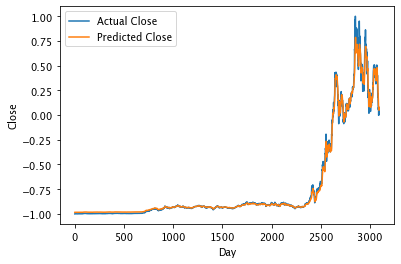

In [132]:
# Use torch.no_grad() to ensure no gradients are calculated during this inference step.
with torch.no_grad():
    # Generate predictions using the trained model on the training data.
    predicted = model(X_train.to(device)).to('cpu').numpy()

# Create a plot to visualize the actual and predicted close prices.
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [133]:
# Flatten the predicted array to a 1D array.
train_predictions = predicted.flatten()

# Create a matrix of zeros with dimensions (number of samples, lookback + 1).
dummies = np.zeros((X_train.shape[0], lookback + 1))

# Set the first column of the dummies matrix to the train_predictions array.
dummies[:, 0] = train_predictions

# Inverse transform the scaled data to its original scale.
dummies = scaler.inverse_transform(dummies)

# Extract the column of interest from the transformed dummies matrix.
train_predictions = dummies[:, 0]

# Return the modified train_predictions array.
train_predictions


array([  4.36408645,   4.35168295,   4.33715941, ..., 218.80788815,
       220.45445861, 216.34743254])

In [134]:
# Create a matrix of zeros with dimensions (number of samples, lookback + 1).
dummies = np.zeros((X_train.shape[0], lookback + 1))

# Set the first column of the dummies matrix to the flattened y_train array.
dummies[:, 0] = y_train.flatten()

# Inverse transform the scaled data to its original scale using the scaler.
dummies = scaler.inverse_transform(dummies)

# Extract the first column (modified y_train) from the transformed dummies matrix.
new_y_train = dummies[:, 0]

# Return the modified new_y_train array.
new_y_train


array([  1.15999971,   1.136667  ,   1.20933347, ..., 222.03999242,
       207.27999891, 214.44000177])

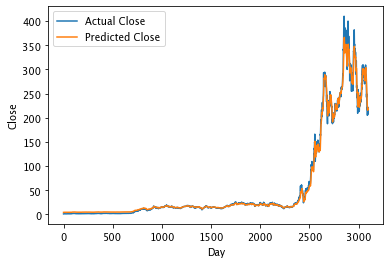

In [135]:
# Create a plot to visualize the modified actual and predicted close prices.
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [136]:
# Generate predictions on the test data using the trained model.
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

# Create a matrix of zeros with dimensions (number of samples, lookback + 1).
dummies = np.zeros((X_test.shape[0], lookback + 1))

# Set the first column of the dummies matrix to the test_predictions array.
dummies[:, 0] = test_predictions

# Inverse transform the scaled data to its original scale using the scaler.
dummies = scaler.inverse_transform(dummies)

# Extract the first column (modified test_predictions) from the transformed dummies matrix.
test_predictions = dummies[:, 0]

# Return the modified test_predictions array.
test_predictions

array([216.13549173, 214.7204512 , 217.99109404, 220.84007277,
       223.06058526, 225.88928951, 227.604131  , 228.72834727,
       224.81909791, 222.00811859, 217.08395421, 209.83570874,
       202.64417759, 192.60060948, 190.81330561, 191.83162915,
       190.86770189, 191.85590004, 189.90042399, 187.27247851,
       184.39604882, 177.48859189, 173.54992077, 176.05628028,
       177.65967   , 179.03818845, 179.31090092, 184.88619412,
       188.70170753, 191.27486073, 188.11989452, 184.94255206,
       180.44002742, 177.06333345, 176.74518616, 172.30234574,
       166.83465714, 161.74564077, 158.71614118, 153.88272459,
       150.58397893, 143.7171197 , 139.3286451 , 131.76946842,
       126.05251582, 116.88940112, 112.49203207, 113.17950022,
       114.33771645, 109.41754848, 108.66295767, 106.89866363,
       106.96349567, 109.48051634, 110.64807784, 113.19771557,
       115.16379186, 115.94259265, 120.00219178, 121.47783035,
       121.76814287, 124.37923762, 130.00698983, 133.72

In [137]:
# Create a matrix of zeros with dimensions (number of samples, lookback + 1).
dummies = np.zeros((X_test.shape[0], lookback + 1))

# Set the first column of the dummies matrix to the flattened y_test array.
dummies[:, 0] = y_test.flatten()

# Inverse transform the scaled data to its original scale using the scaler.
dummies = scaler.inverse_transform(dummies)

# Extract the first column (modified y_test) from the transformed dummies matrix.
new_y_test = dummies[:, 0]

# Return the modified new_y_test array.
new_y_test

array([211.24999994, 222.41999728, 224.63999956, 225.08999646,
       228.52000384, 227.53999346, 227.82000731, 214.97999637,
       215.30999811, 207.47000096, 197.08000169, 191.30000279,
       177.58999475, 190.72000066, 195.97000131, 190.94999691,
       194.41999811, 186.91999772, 183.16999867, 180.19000189,
       167.86999589, 169.91000276, 183.19999765, 182.86000107,
       182.91999751, 180.83000199, 194.69999672, 194.69999672,
       194.86000093, 182.44999723, 179.82000786, 174.03999297,
       173.44000116, 179.05000406, 167.82000724, 160.9499984 ,
       156.80000176, 157.6699981 , 150.22999796, 149.869998  ,
       137.80000534, 137.57000452, 125.3500002 , 123.14999978,
       109.09999822, 112.71000101, 121.81999876, 123.17999724,
       108.09999969, 113.64000141, 110.33999469, 113.05999775,
       119.76999781, 118.85000063, 123.22000401, 123.55999754,
       122.40000241, 131.49000591, 128.77999997, 127.17000033,
       133.41999875, 143.74999872, 143.89000107, 144.42

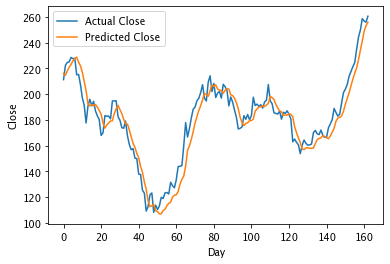

In [138]:
# Visualize actual and predicted close prices over days
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()